## DATA 558: Homework 3

Geoffrey Li

April 26, 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1

### 1.1: Load and Process Data

In [2]:
spam = pd.read_csv('./spam.data', sep='\s+', header=None)

In [3]:
spam.shape

(4601, 58)

In [4]:
# Create our X matrix with the predictors and y vector with the response
X = spam.iloc[:,0:57]
y = spam.iloc[:,57]

In [5]:
# Replace 0's with -1's in the response
y = y.replace(0, -1)

In [6]:
from sklearn.model_selection import train_test_split

# Divide the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
from sklearn import preprocessing

# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# We need to convert the y's to arrays

y_train = np.asarray(y_train).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

### 1.2: Define Functions

In [2]:
def computegrad(x, y, beta, lamb):
    p = np.identity(len(x)) - np.diag(1/(1+np.exp(np.multiply(-y,x@beta))).reshape(1,-1)[0])
    return -1/len(x)*x.T@p@y + 2*lamb*beta

In [3]:
def computeobj(x, y, beta, lamb):
    return 1/len(x)*np.sum(np.log(1+np.exp(np.multiply(-y,x@beta)))) + lamb*np.sum(beta**2)

In [4]:
def backtracking(curr_beta, eta_t=1, alpha=0.5, gamma=0.5, max_iter=100):
    """
    Perform backtracking line search
    Inputs:
      - curr_beta: Current beta point
      - eta_t: Starting (maximum) step size
      - alpha: Constant used to define sufficient decrease condition
      - gamma: Fraction by which we decrease t if the previous t doesn't work
      - max_iter: Maximum number of iterations to run the algorithm
    Output:
      - eta_t: Step size to use
    """
    grad_curr_beta = computegrad(X_train, y_train, curr_beta, lamb)  # Gradient at current beta
    norm_grad_curr_beta = np.sqrt(np.sum(grad_curr_beta**2))  # Norm of the gradient at current beta
    found_eta_t = False
    i = 0  # Iteration counter
    
    while (found_eta_t is False and i < max_iter):     
        if (computeobj(X_train, y_train, curr_beta-eta_t*grad_curr_beta, lamb) < 
            computeobj(X_train, y_train, curr_beta, lamb) - alpha*eta_t*norm_grad_curr_beta**2):
#             print("Found step size")
#             print("Left: "+str(computeobj(X_train, y_train, curr_beta-eta_t*grad_curr_beta, lamb)))
#             print("Right: "+str(computeobj(X_train, y_train, curr_beta, lamb) - alpha*eta_t*norm_grad_curr_beta**2))
            found_eta_t = True
        elif i == max_iter - 1:
            raise('Maximum number of iterations of backtracking reached')
        else:
            eta_t *= gamma
            i += 1
#             print("BT Iteration "+str(i)+"; step size = "+str(eta_t))
    
    return eta_t

In [5]:
def initstepsize(x, lamb):
    return max(np.linalg.eigh(1/len(x)*x.T@x)[0]) + lamb

In [6]:
def graddescent(beta_init, ss_init, targ_acc):

    beta_values = list()
    beta_values.append(beta_init)
    
    grad_beta = computegrad(X_train, y_train, beta_init, lamb)
    norm_grad_beta = np.sqrt(np.sum(grad_beta**2))
    tuned_step_size = ss_init
    
    # Take the initial step 
#     beta_values.append(beta_init - tuned_step_size*grad_beta) 
    t = 0
    
    while norm_grad_beta > targ_acc:

        tuned_step_size = backtracking(beta_values[t], eta_t=tuned_step_size, alpha=0.5, gamma=0.8, max_iter=100)
        beta_values.append(beta_values[t] - tuned_step_size*grad_beta)
        
#         print("Gradient Descent "+str(t))
#         print("Norm_grad_beta: "+str(norm_grad_beta))
#         print("Tuned_step_size: "+str(tuned_step_size))
#         print("")
        
        t += 1
        
        grad_beta = computegrad(X_train, y_train, beta_values[t], lamb)
        norm_grad_beta = np.sqrt(np.sum(grad_beta**2))
        

    return beta_values
    

In [7]:
def fastgradalgo(beta_init, theta_init, ss_init, targ_acc):
    beta_values = list()
    beta_values.append(beta_init)
    theta = theta_init
    
    grad_theta = computegrad(X_train, y_train, theta, lamb)
#     norm_grad_theta = np.sqrt(np.sum(grad_theta**2))
    
    grad_beta = computegrad(X_train, y_train, beta_init, lamb)
    norm_grad_beta = np.sqrt(np.sum(grad_beta**2))
    
    tuned_step_size = ss_init
    
    t = 0
    
    while norm_grad_beta > targ_acc:
        grad_theta = computegrad(X_train, y_train, theta, lamb)
#         norm_grad_theta = np.sqrt(np.sum(grad_theta**2))
        
        tuned_step_size = backtracking(beta_values[t], eta_t=tuned_step_size, alpha=0.5, gamma=0.8, max_iter=100)
        
        beta_values.append(theta - tuned_step_size*grad_theta)
        theta = beta_values[t+1] + (t/(t+3))*(beta_values[t+1] - beta_values[t])
        
        t += 1
        
        grad_beta = computegrad(X_train, y_train, beta_values[t], lamb)
        norm_grad_beta = np.sqrt(np.sum(grad_beta**2))
        
    return beta_values

### 1.3: Run Gradient Descent

In [15]:
init_beta = np.zeros(X_train.shape[1]).reshape(-1, 1)
lamb = 0.1
init_eta = initstepsize(X_train, lamb)
target_accuracy = 10**-4

beta_results = graddescent(init_beta, init_eta, target_accuracy)

# Create array of Objective Values at each iteration
obj_value_results = list(map(lambda bt: computeobj(X_train, y_train, bt, lamb), beta_results))

In [16]:
# Beta_T for Gradient Descent
beta_results[len(beta_results)-1]

array([[ 0.02970867],
       [-0.02223558],
       [ 0.08670667],
       [ 0.05880021],
       [ 0.1753553 ],
       [ 0.12134703],
       [ 0.29468427],
       [ 0.13220617],
       [ 0.12261813],
       [ 0.05085066],
       [ 0.13945624],
       [-0.03880173],
       [ 0.05659804],
       [ 0.03271692],
       [ 0.10923295],
       [ 0.19740009],
       [ 0.15748288],
       [ 0.11929686],
       [ 0.11495324],
       [ 0.1291749 ],
       [ 0.23579835],
       [ 0.10139351],
       [ 0.2502834 ],
       [ 0.15326302],
       [-0.14763027],
       [-0.10449629],
       [-0.12074387],
       [-0.03506742],
       [-0.05008774],
       [-0.07531244],
       [-0.03263821],
       [-0.01355137],
       [-0.07909091],
       [-0.01606413],
       [-0.0565662 ],
       [-0.00413522],
       [-0.08060725],
       [-0.02236642],
       [-0.05793896],
       [ 0.01551776],
       [-0.05250636],
       [-0.09655855],
       [-0.05870214],
       [-0.06653568],
       [-0.11087184],
       [-0

In [17]:
# Objective Value for Gradient Descent
obj_value_results[len(obj_value_results)-1]

0.45068554215327056

### 1.4: Run Fast Gradient Algorithm

In [18]:
init_beta = np.zeros(X_train.shape[1]).reshape(-1, 1)
init_theta = np.zeros(X_train.shape[1]).reshape(-1, 1)
lamb = 0.1
init_eta = initstepsize(X_train, lamb)
target_accuracy = 10**-4

beta_results_fg = fastgradalgo(init_beta, init_theta, init_eta, target_accuracy)

# Create array of Objective Values at each iteration
obj_value_results_fg = list(map(lambda bt: computeobj(X_train, y_train, bt, lamb), beta_results_fg))

In [19]:
# Beta_T for Fast Gradient Descent
beta_T = beta_results_fg[len(beta_results_fg)-1]
print(beta_T.round(4))

[[ 0.0297]
 [-0.0222]
 [ 0.0867]
 [ 0.0588]
 [ 0.1753]
 [ 0.1213]
 [ 0.2949]
 [ 0.1321]
 [ 0.1225]
 [ 0.0508]
 [ 0.1393]
 [-0.0388]
 [ 0.0565]
 [ 0.0327]
 [ 0.1092]
 [ 0.1974]
 [ 0.1574]
 [ 0.1192]
 [ 0.115 ]
 [ 0.1292]
 [ 0.2357]
 [ 0.1015]
 [ 0.2504]
 [ 0.1533]
 [-0.1478]
 [-0.1045]
 [-0.1208]
 [-0.035 ]
 [-0.0501]
 [-0.0754]
 [-0.0327]
 [-0.0135]
 [-0.0791]
 [-0.016 ]
 [-0.0566]
 [-0.004 ]
 [-0.0806]
 [-0.0223]
 [-0.0579]
 [ 0.0155]
 [-0.0524]
 [-0.0966]
 [-0.0587]
 [-0.0666]
 [-0.1109]
 [-0.1104]
 [-0.0453]
 [-0.0598]
 [-0.0677]
 [-0.0326]
 [-0.0281]
 [ 0.1598]
 [ 0.2558]
 [ 0.0603]
 [ 0.067 ]
 [ 0.1337]
 [ 0.1668]]


In [20]:
# Objective Value for Fast Gradient Descent
obj_value_results_fg[len(obj_value_results_fg)-1]

0.4506855378615487

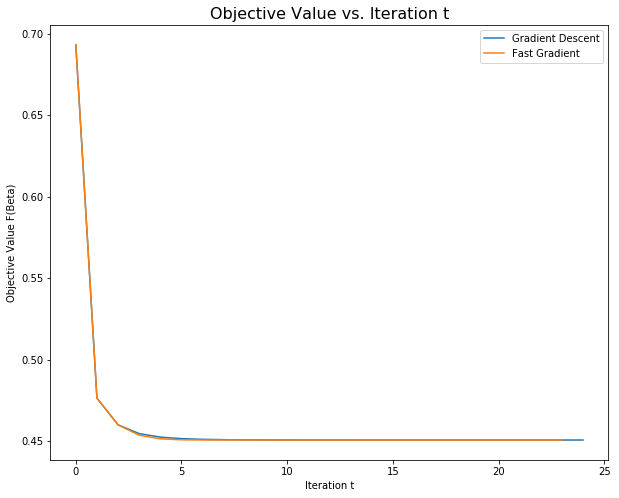

In [21]:
plt.figure(figsize=(10,8))
plt.plot(range(0, len(obj_value_results)),obj_value_results)
plt.plot(range(0, len(obj_value_results_fg)),obj_value_results_fg)
plt.legend(['Gradient Descent', 'Fast Gradient'], loc='upper right')
plt.title('Objective Value vs. Iteration t', fontsize=16)
plt.xlabel('Iteration t')
plt.ylabel('Objective Value F(Beta)');

We see in the above graph that the Fast Gradient (24 iterations) converages slightly faster than the Gradient Descent algorithm (25 iterations). I suspect the convergence was relatively fast for this particular problem, and so the speed increase of the Fast Gradient wasn't fully realized. They both converge to the objective value of ~0.45 fairly quickly (within 5 iterations).

### 1.5 Using sklearn.LogisticRegression

In [22]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty='l2', C=1/(2*lamb*len(X_train)), fit_intercept=False)
classifier.fit(X_train, y_train)

classifier.score(X_test, y_test)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.893136403127715

In [23]:
beta_star = classifier.coef_.reshape(-1,1)
print('Beta_*')
print(beta_star.round(4))

Beta_*
[[ 0.0297]
 [-0.0222]
 [ 0.0867]
 [ 0.0588]
 [ 0.1754]
 [ 0.1213]
 [ 0.2948]
 [ 0.1322]
 [ 0.1226]
 [ 0.0508]
 [ 0.1394]
 [-0.0388]
 [ 0.0566]
 [ 0.0327]
 [ 0.1092]
 [ 0.1974]
 [ 0.1574]
 [ 0.1193]
 [ 0.115 ]
 [ 0.1292]
 [ 0.2358]
 [ 0.1014]
 [ 0.2503]
 [ 0.1533]
 [-0.1477]
 [-0.1045]
 [-0.1208]
 [-0.035 ]
 [-0.0501]
 [-0.0753]
 [-0.0327]
 [-0.0135]
 [-0.0791]
 [-0.0161]
 [-0.0566]
 [-0.0041]
 [-0.0806]
 [-0.0224]
 [-0.0579]
 [ 0.0155]
 [-0.0525]
 [-0.0966]
 [-0.0587]
 [-0.0665]
 [-0.1109]
 [-0.1104]
 [-0.0453]
 [-0.0598]
 [-0.0676]
 [-0.0326]
 [-0.0281]
 [ 0.1598]
 [ 0.2556]
 [ 0.0603]
 [ 0.067 ]
 [ 0.1337]
 [ 0.1668]]


In [24]:
print('F(Beta_*)')
print(computeobj(X_train, y_train, beta_star, lamb))

F(Beta_*)
0.4506855262964716


### 1.6 Comparing $\beta_T$ with $\beta^*$ using relative error
Relative to $\beta^*$

In [25]:
print('Vector Difference of Beta')
print((beta_T - beta_star).round(4))

Vector Difference of Beta
[[-0.    ]
 [ 0.    ]
 [ 0.    ]
 [-0.    ]
 [-0.    ]
 [-0.    ]
 [ 0.0001]
 [-0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.0001]
 [ 0.    ]
 [-0.    ]
 [-0.    ]
 [-0.    ]
 [-0.    ]
 [-0.0001]
 [-0.    ]
 [ 0.    ]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [ 0.0001]
 [ 0.    ]
 [-0.0001]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [ 0.    ]
 [-0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.    ]
 [ 0.0001]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.    ]
 [-0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.    ]
 [-0.    ]
 [-0.    ]
 [-0.    ]
 [ 0.    ]
 [ 0.0001]
 [ 0.    ]
 [-0.    ]
 [ 0.    ]
 [-0.    ]]


In [26]:
print('Relative Error of Beta')
print(np.sqrt(np.sum((beta_T - beta_star)**2))/np.sqrt(np.sum(beta_star**2)))

Relative Error of Beta
0.00033329243208579537


In [27]:
print('Difference of Objective Value')
print(computeobj(X_train, y_train, beta_T, lamb)-computeobj(X_train, y_train, beta_star, lamb))

Difference of Objective Value
1.156507711819188e-08


In [28]:
print('Relative Difference of Objective Value')
print((computeobj(X_train, y_train, beta_T, lamb)-computeobj(X_train, y_train, beta_star, lamb))/
      computeobj(X_train, y_train, beta_star, lamb))

Relative Difference of Objective Value
2.566107949644715e-08


We see above that our Beta and Objective Values obtained by the Fast Gradient almost exactly match those obtained by sklearn.Logistic Regression, giving me confidence that the fast gradient algorithm was implemented correctly.

### 1.7: Run CV to find optimal value of $\lambda$

In [29]:
from sklearn.model_selection import GridSearchCV

# Create a classifier
classifier = LogisticRegression()
parameters = {'C':[1/(len(X_train)*2*10**i) for i in range(-5, 1)]}
clf = GridSearchCV(classifier, parameters, cv=5)

# We learn the model on the training set
clf.fit(X_train, y_train)

# Now predict the spam types on the test set
classifier_predicted = clf.predict(X_test)



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was 

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
print("Best C:", clf.best_params_['C'])
print("Best Lamba: ",1/(clf.best_params_['C']*len(X_train)*2))
print("Accuracy: {:.2f}%".format(np.mean(y_test.reshape(1,-1) == classifier_predicted)*100))

Best C: 14.492753623188404
Best Lamba:  1e-05
Accuracy: 90.36%


There is no significant improvement in accuracy for any smaller values of $\lambda < 0.1$, so we will go with $\lambda = 0.1$ as the optimal value. See above for the Beta and Objective values.

### 1.8 Misclassification Error

In [8]:
def misclassificationerror(y, x, b):
    return 1 - np.mean(
        np.fromiter(map(lambda p: 1 if p >= 0.5 else -1, 1/(1+np.exp(-x@b))), 
                    dtype=np.int).reshape(-1,1) == y)

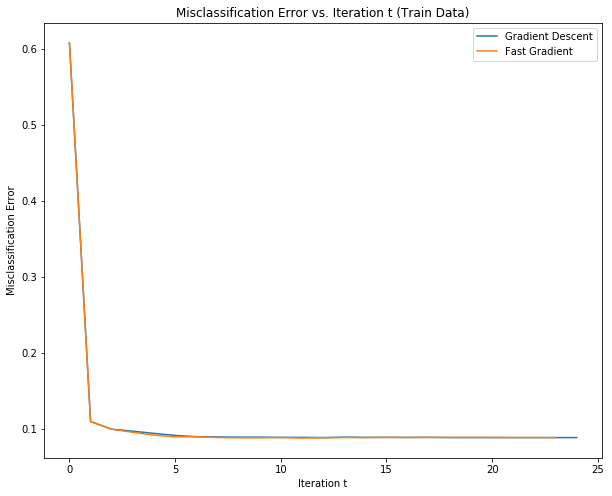

In [32]:
plt.figure(figsize=(10,8))
plt.plot(range(0,len(beta_results)),list(map(lambda b: misclassificationerror(y_train,X_train,b),beta_results)))
plt.plot(range(0,len(beta_results_fg)),list(map(lambda b: misclassificationerror(y_train,X_train,b),beta_results_fg)))
plt.legend(['Gradient Descent', 'Fast Gradient'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t (Train Data)')
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

The above plot shows the misclassification error vs. iteration, for the Fast Gradient vs Gradient Descent on the Training Data. They both appear to show similar misclassification rates, with the fast gradient having slightly lower error rates slightly sooner.

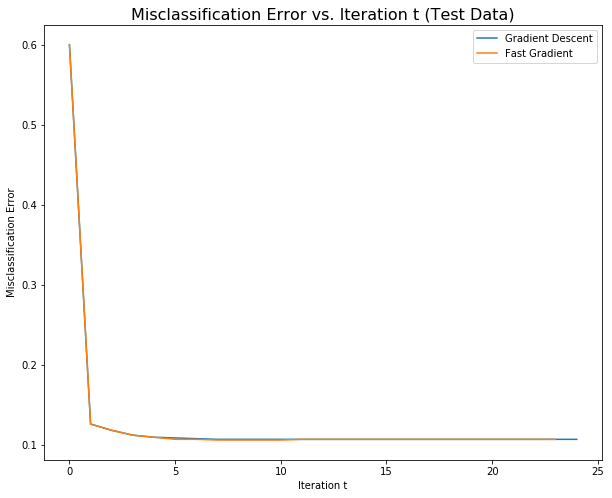

In [33]:
plt.figure(figsize=(10,8))
plt.plot(range(0,len(beta_results)),list(map(lambda b: misclassificationerror(y_test,X_test,b),beta_results)))
plt.plot(range(0,len(beta_results_fg)),list(map(lambda b: misclassificationerror(y_test,X_test,b),beta_results_fg)))
plt.legend(['Gradient Descent', 'Fast Gradient'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t (Test Data)', fontsize=16)
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

The above plot shows the misclassification error vs. iteration, for the Fast Gradient vs Gradient Descent on the Test Data. They both appear to show similar misclassification rates, with the fast gradient having slightly lower error rates slightly sooner.

## Exercise 2

(a) As $\lambda$ increases from 0, we would expect the misclassification error to (ii) decrease initially, and then eventually start increasing in a U shape. This is because as $\lambda$ increases from 0 (penalty parameter increase), the features with low predictive power will become more insignificant. Thus, the model becomes better at generalizing (avoids overfitting) to the test dataset. The misclassification error rate is at a minimum at this point. However, if $\lambda$ becomes too large, the penalty parameter is too great, and even critical features become insignificant in the model. At this point, the misclassification error grows again.


(b) As $\lambda$ increases from 0, we would expect the misclassification error to (iii) steadily increase. This is because the model becomes progressively worse at fitting to the training dataset, so the error steadily increases. 


## Exercise 3

CPU Version
- Fitting time: 1.196605
- Testing time: 993.196478

GPU Version
- Fitting time: 0.964353
- Testing time: 45.230758

URL
- https://s3.amazonaws.com/data558geoffli/hw3/output.txt


How long it took to complete exercise
- After getting through the AWS tutorial, around 15-30 min (including run time).


## Exercise 4

### 4.1: Loading and processing data

In [9]:
path = './q4/'

In [10]:
X_train = np.load(path+'train_features.npy')
y_train = np.load(path+'train_labels.npy')

X_val = np.load(path+'val_features.npy')
y_val = np.load(path+'val_labels.npy')

X_test = np.load(path+'test_features.npy')

In [11]:
from sklearn import preprocessing

# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
# X_train = X_train[list(range(0,500))+list(range(500,1000))]
# y_train = y_train[list(range(0,500))+list(range(500,1000))]

In [13]:
y_train = np.fromiter(map(lambda n: 1 if n == 0 else -1, y_train), dtype=int).reshape(-1, 1)

In [14]:
y_val = np.fromiter(map(lambda n: 1 if n == 0 else -1, y_val), dtype=int).reshape(-1, 1)

### 4.2: Training Classifier using Fast Gradient on Extracted Features, classes 0 and 1

In [15]:
init_beta = np.zeros(X_train.shape[1]).reshape(-1, 1)
init_theta = np.zeros(X_train.shape[1]).reshape(-1, 1)
lamb = 1
init_eta = initstepsize(X_train, lamb)
target_accuracy = 10**-4

comp_beta = fastgradalgo(init_beta, init_theta, init_eta, target_accuracy)

# Create array of Objective Values at each iteration
comp_obj_vals = list(map(lambda bt: computeobj(X_train, y_train, bt, lamb), comp_beta))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [16]:
misclassificationerror(y_train, X_train, comp_beta[len(comp_beta)-1])

0.19020000000000004

In [17]:
misclassificationerror(y_val, X_val, comp_beta[len(comp_beta)-1])

0.19099999999999995

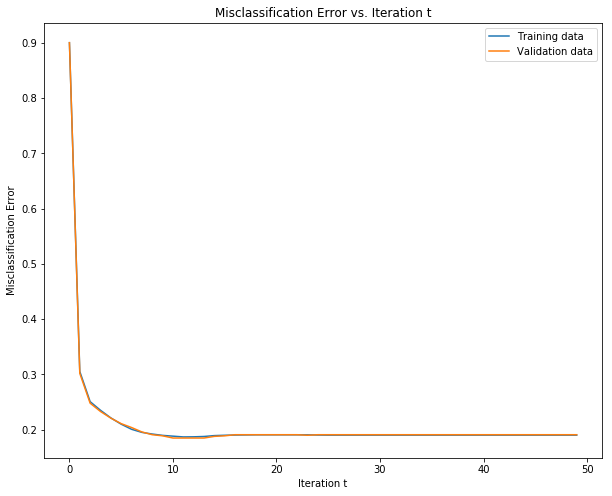

In [18]:
plt.figure(figsize=(10,8))
plt.plot(range(0,len(comp_beta)),list(map(lambda b: misclassificationerror(y_train,X_train,b),comp_beta)))
plt.plot(range(0,len(comp_beta)),list(map(lambda b: misclassificationerror(y_val,X_val,b),comp_beta)))
plt.legend(['Training data', 'Validation data'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t')
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

### 4.3 Run CV to find the best $\lambda$

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Create a classifier
classifier = LogisticRegression(penalty='l2', fit_intercept=False)
parameters = {'C':[1/(len(X_train)*2*10**i) for i in range(-10, 1)]}
clf = GridSearchCV(classifier, parameters, cv=5)

# We learn the model on the training set
clf.fit(X_train, y_train)

# Now predict the spam types on the test set
classifier_predicted = clf.predict(X_val)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [20]:
print("Best C:", clf.best_params_['C'])
print("Best Lamba: ",1/(clf.best_params_['C']*len(X_train)*2))
print("Accuracy: {:.2f}%".format(np.mean(y_val.reshape(1,-1) == classifier_predicted)*100))

Best C: 10.0
Best Lamba:  1e-05
Accuracy: 75.00%


### 4.4 Re-running with best $\lambda$

In [21]:
from datetime import datetime
print(datetime.now())

2019-04-27 20:53:33.004035


In [22]:
init_beta = np.zeros(X_train.shape[1]).reshape(-1, 1)
init_theta = np.zeros(X_train.shape[1]).reshape(-1, 1)
lamb = 0.01
init_eta = initstepsize(X_train, lamb)
target_accuracy = 10**-4

comp_beta_opt = fastgradalgo(init_beta, init_theta, init_eta, target_accuracy)

# Create array of Objective Values at each iteration
comp_obj_vals_opt = list(map(lambda bt: computeobj(X_train, y_train, bt, lamb), comp_beta_opt))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [23]:
misclassificationerror(y_train, X_train, comp_beta_opt[len(comp_beta_opt)-1])

0.024800000000000044

In [24]:
misclassificationerror(y_val, X_val, comp_beta_opt[len(comp_beta_opt)-1])

0.21299999999999997

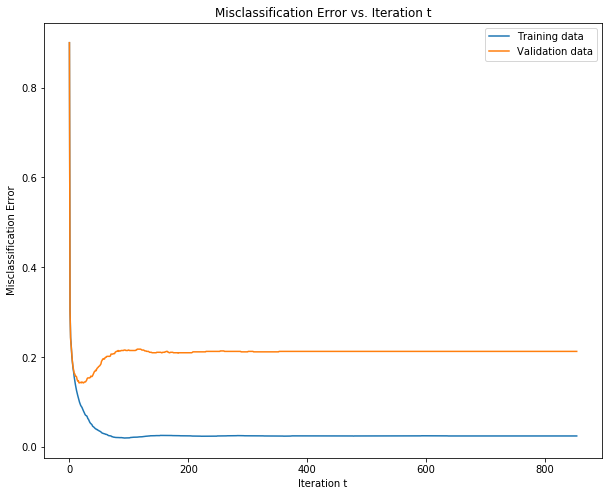

In [25]:
plt.figure(figsize=(10,8))
plt.plot(range(0,len(comp_beta_opt)),list(map(lambda b: misclassificationerror(y_train,X_train,b),comp_beta_opt)))
plt.plot(range(0,len(comp_beta_opt)),list(map(lambda b: misclassificationerror(y_val,X_val,b),comp_beta_opt)))
plt.legend(['Training data', 'Validation data'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t')
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

In [26]:
print(datetime.now())

2019-04-28 01:07:28.308509


### 4.5 Trying with sklearn.LogisticRegressionCV

In [27]:
# from sklearn.linear_model import LogisticRegressionCV

# classifier = LogisticRegressionCV(Cs=10, penalty='l2', fit_intercept=False, cv=5)

# classifier.fit(X_train, y_train)

# classifier.score(X_val, y_val)

### 4.6 Make Predictions and create submission CSV

In [32]:
comp_beta_opt_T = comp_beta_opt[len(comp_beta_opt)-1]
y_preds = np.fromiter(map(lambda p: 1 if p >= 0.5 else -1, 1/(1+np.exp(-X_test@comp_beta_opt_T))), dtype=np.int)

In [33]:
y_preds = np.fromiter(map(lambda y: 0 if y == 1 else 1, y_preds), dtype=int)

In [34]:
pd.DataFrame({'preds':y_preds}).groupby('preds').size()

preds
0    255
1    745
dtype: int64

In [35]:
pd.DataFrame({'Category':y_preds}).reset_index()\
.rename(columns={'index':'Id'}).to_csv('./comp-submission_3.csv', index=False)